To access the dataset, stored in the google drive, required to train the model, the google drive is first mounted to the code

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
from random import shuffle

opens the dataset files and assigns variables to be worked upon later
displayes the size of the data set to be trained and the data set to be tested with

In [27]:
data_dir = "/content/gdrive/MyDrive/lego-brick-images/dataset"
all_files = pd.Series(
    [fn.lstrip(f"{data_dir}/") for fn in glob.glob(f"{data_dir}/*.png")])

with open("/content/gdrive/MyDrive/lego-brick-images/validation.txt", 'r') as f:
    val_files = pd.Series([fn.strip() for fn in f.readlines()])
train_files = all_files[~all_files.isin(val_files)]

train_files = train_files.sample(frac=1)
val_files = val_files.sample(frac=1)

def filename_to_label(file_path):
    filename = file_path.split(os.path.sep)[-1]
    parts = filename.replace(".png", "").split(" ")[:-1]
    return "".join(parts)

train_files = [f"{data_dir}/{f}" for f in train_files]
train_labels = [filename_to_label(f) for f in train_files]
val_files = [f"{data_dir}/{f}" for f in val_files]
val_labels = [filename_to_label(f) for f in val_files]


len(train_files), len(val_files)

(32000, 8000)

In [28]:
train_files[0:3], train_labels[0:3], val_files[0:3], val_labels[0:3]

(['/content/gdrive/MyDrive/lego-brick-images/dataset/6143 Brick D16 w cross 306L.png',
  '/content/gdrive/MyDrive/lego-brick-images/dataset/3063 Curved Brick 2 Knobs 100L.png',
  '/content/gdrive/MyDrive/lego-brick-images/dataset/43857 beam 1x2 087L.png'],
 ['6143BrickD16wcross', '3063CurvedBrick2Knobs', '43857beam1x2'],
 ['/content/gdrive/MyDrive/lego-brick-images/dataset/3046 roof corner inside tile 2x2 033L.png',
  '/content/gdrive/MyDrive/lego-brick-images/dataset/27925 flat tile round 2x2 029L.png',
  '/content/gdrive/MyDrive/lego-brick-images/dataset/3623 Plate 1x3 014R.png'],
 ['3046roofcornerinsidetile2x2', '27925flattileround2x2', '3623Plate1x3'])

Import's tensor flow, this step is ran seperately as tensorflow takes time to import into the code

In [29]:
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

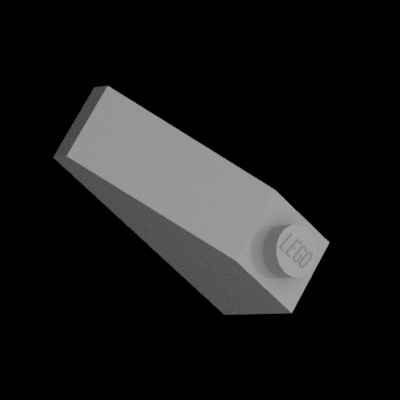

In [ ]:
PIL.Image.open(train_files[0])

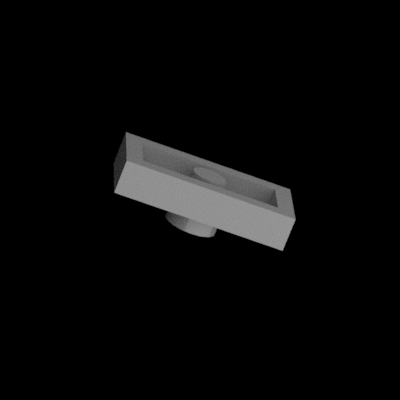

In [ ]:
PIL.Image.open(val_files[1337])

converts the training labels into a list of sets and converts it into a tensor


In [30]:
tf.convert_to_tensor(list(set(train_labels)))

<tf.Tensor: shape=(50,), dtype=string, numpy=
array([b'3063CurvedBrick2Knobs', b'43857beam1x2', b'33909plate2knobs2x2',
       b'3038rooftile2x3', b'3070FlatTile1x1', b'54200rooftile1x1',
       b'18654beam1M', b'3037rooftile1x4',
       b'3045roofcorneroutsidetile2x2', b'3675rooftileoutside3x3',
       b'3623Plate1x3', b'14719flattilecorner2x2', b'3298rooftile2x3',
       b'2780Pegwithfriction', b'3794Plate1X2with1Knob',
       b'6143BrickD16wcross', b'3004brick1x2', b'2357brickcorner1x2x2',
       b'85984rooftile1x2', b'3022Plate2x2', b'3010brick1x4',
       b'3021plate2x3', b'6632lever3M', b'4274ConnectorPegwKnob',
       b'3700TechnicBrick1x2', b'3024plate1x1',
       b'3046roofcornerinsidetile2x2', b'3040rooftile1x2',
       b'3062RoundBrick1x1', b'3659brickbow1x4', b'4286rooftile1x3',
       b'4490brickbow1x3', b'41678CrossBlockFork2x2',
       b'99301rooftileinside3x3', b'3622brick1x3', b'3039rooftile2x2',
       b'3005brick1x1', b'27925flattileround2x2', b'3068flattile2x2',
   

In [31]:
class_names = tf.convert_to_tensor(list(set(train_labels)))


def get_label(file_path, class_names):
    filename = tf.strings.split(file_path, os.path.sep)[-1]
    parts = tf.strings.split(tf.strings.regex_replace(filename, ".png", ""), " ")[:-1]
    label = tf.strings.reduce_join(parts)

    one_hot = label == class_names
    return tf.argmax(one_hot)

def decode_img(img, img_height, img_width):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path, img_height=128, img_width=128):
    label = get_label(file_path, class_names)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_height, img_width)
    return img , label

# get_label(test_files[1337], class_names)
img, lb = process_path(train_files[0])
# img.shape, lb

In [32]:
train = (
    tf.data.Dataset
    .from_tensor_slices(train_files)
    .map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
)
    

val = (
    tf.data.Dataset
    .from_tensor_slices(val_files)
    .map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
)

In [33]:
train.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for images, labels in val.shuffle(10).take(4):
    print("Image shape: ", images.numpy().shape)
    print("Label: ", labels.numpy())

Image shape:  (128, 128, 3)
Label:  6
Image shape:  (128, 128, 3)
Label:  24
Image shape:  (128, 128, 3)
Label:  0
Image shape:  (128, 128, 3)
Label:  48


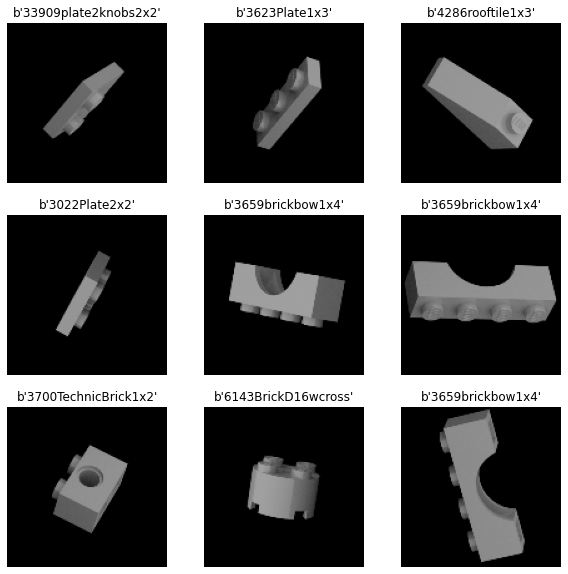

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for images, labels in train.shuffle(50).take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels].numpy())
    plt.axis("off")
    i = i + 1

In [ ]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 128, 3)
()


In [34]:
batch_size = 128
train_ds = train.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
img_height, img_width = (128, 128)
num_classes = len(class_names)

model= Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(8, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(num_classes))

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Loads the saved model

In [37]:
model = tf.keras.models.load_model('saved_model/my_model')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1

An Epoch is 1 runthrough of a training cycle

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
186/250 [=====================>........] - ETA: 15:45 - loss: 3.8663 - accuracy: 0.1190

Displays the graph of accuracy (left) and loss (right) of the training and validation

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

saves the model in content

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')